In [1]:
import cv2
import torch
from pathlib import Path
import os
import numpy as np

from matplotlib import pyplot as plt

In [2]:
def letterbox(im, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True, stride=32):
    # Resize and pad image while meeting stride-multiple constraints
    shape = im.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better val mAP)
        r = min(r, 1.0)

    # Compute padding
    ratio = r, r  # width, height ratios
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding
    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding
    elif scaleFill:  # stretch
        dw, dh = 0.0, 0.0
        new_unpad = (new_shape[1], new_shape[0])
        ratio = new_shape[1] / shape[1], new_shape[0] / shape[0]  # width, height ratios

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        im = cv2.resize(im, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return im, ratio, (dw, dh)

In [3]:
IMG_FORMATS = 'bmp', 'dng', 'jpeg', 'jpg', 'mpo', 'png', 'tif', 'tiff', 'webp', 'pfm'  # include image suffixes
VID_FORMATS = 'asf', 'avi', 'gif', 'm4v', 'mkv', 'mov', 'mp4', 'mpeg', 'mpg', 'ts', 'wmv'  # include video suffixes

In [4]:
class LoadImages:
    # YOLOv5 image/video dataloader, i.e. `python detect.py --source image.jpg/vid.mp4`
    def __init__(self, path, img_size=640, stride=32, auto=True, transforms=None, vid_stride=1):
        if isinstance(path, str) and Path(path).suffix == ".txt":  # *.txt file with img/vid/dir on each line
            path = Path(path).read_text().rsplit()
        files = []
        for p in sorted(path) if isinstance(path, (list, tuple)) else [path]:
            p = str(Path(p).resolve())
            if '*' in p:
                files.extend(sorted(glob.glob(p, recursive=True)))  # glob
            elif os.path.isdir(p):
                files.extend(sorted(glob.glob(os.path.join(p, '*.*'))))  # dir
            elif os.path.isfile(p):
                files.append(p)  # files
            else:
                raise FileNotFoundError(f'{p} does not exist')

        images = [x for x in files if x.split('.')[-1].lower() in IMG_FORMATS]
        videos = [x for x in files if x.split('.')[-1].lower() in VID_FORMATS]
        ni, nv = len(images), len(videos)

        self.img_size = img_size
        self.stride = stride
        self.files = images + videos
        self.nf = ni + nv  # number of files
        self.video_flag = [False] * ni + [True] * nv
        self.mode = 'image'
        self.auto = auto
        self.transforms = transforms  # optional
        self.vid_stride = vid_stride  # video frame-rate stride
        if any(videos):
            self._new_video(videos[0])  # new video
        else:
            self.cap = None
        assert self.nf > 0, f'No images or videos found in {p}. ' \
                            f'Supported formats are:\nimages: {IMG_FORMATS}\nvideos: {VID_FORMATS}'

    def __iter__(self):
        self.count = 0
        print('---')
        return self

    def __next__(self):
        if self.count == self.nf:
            raise StopIteration
        path = self.files[self.count]

        if self.video_flag[self.count]:
            # Read video
            self.mode = 'video'
            for _ in range(self.vid_stride):
                self.cap.grab()
            ret_val, im0 = self.cap.retrieve()
            while not ret_val:
                self.count += 1
                self.cap.release()
                if self.count == self.nf:  # last video
                    raise StopIteration
                path = self.files[self.count]
                self._new_video(path)
                ret_val, im0 = self.cap.read()

            self.frame += 1
            # im0 = self._cv2_rotate(im0)  # for use if cv2 autorotation is False
            s = f'video {self.count + 1}/{self.nf} ({self.frame}/{self.frames}) {path}: '

        else:
            # Read image
            self.count += 1
            im0 = cv2.imread(path)  # BGR
            assert im0 is not None, f'Image Not Found {path}'
            s = f'image {self.count}/{self.nf} {path}: '

        if self.transforms:
            im = self.transforms(im0)  # transforms
        else:
            im = letterbox(im0, self.img_size, stride=self.stride, auto=self.auto)[0]  # padded resize
            im = im.transpose((2, 0, 1))[::-1]  # HWC to CHW, BGR to RGB
            im = np.ascontiguousarray(im)  # contiguous

        return path, im, im0, self.cap, s

    def _new_video(self, path):
        # Create a new video capture object
        self.frame = 0
        self.cap = cv2.VideoCapture(path)
        self.frames = int(self.cap.get(cv2.CAP_PROP_FRAME_COUNT) / self.vid_stride)
        self.orientation = int(self.cap.get(cv2.CAP_PROP_ORIENTATION_META))  # rotation degrees
        # self.cap.set(cv2.CAP_PROP_ORIENTATION_AUTO, 0)  # disable https://github.com/ultralytics/yolov5/issues/8493

    def _cv2_rotate(self, im):
        # Rotate a cv2 video manually
        if self.orientation == 0:
            return cv2.rotate(im, cv2.ROTATE_90_CLOCKWISE)
        elif self.orientation == 180:
            return cv2.rotate(im, cv2.ROTATE_90_COUNTERCLOCKWISE)
        elif self.orientation == 90:
            return cv2.rotate(im, cv2.ROTATE_180)
        return im

    def __len__(self):
        return self.nf  # number of files

In [5]:
device = torch.device("cuda") if torch.cuda.is_available else torch.device("cpu")

In [25]:
model = torch.load('../models/model_densnet_121_softmax.pt').to(device)

In [26]:
source = '../data/2022-06-20 13-25-14.mp4'
bs = 1  # batch_size
dataset = LoadImages(source)
vid_path, vid_writer = [None] * bs, [None] * bs

In [27]:
def draw_text(img, pred):
    font = cv2.FONT_HERSHEY_SIMPLEX
    bottomLeftCornerOfText = (10,500)
    fontScale = 2
    fontColor = (255,255,255)
    thickness = 5
    lineType = 2
    str_view = f'esophagitis: {round(pred[0][0].item() *100, 4)}%'
    cv2.putText(img, str_view,
        bottomLeftCornerOfText,
        font,
        fontScale,
        fontColor,
        thickness,
        lineType)
    str_view =f'normal-z-line: {round(pred[0][1].item()*100, 4)}%'
    bottomLeftCornerOfText = (10,200)
    cv2.putText(img, str_view,
        bottomLeftCornerOfText,
        font,
        fontScale,
        fontColor,
        thickness,
        lineType)
    
#     plt.imshow(np.array(img),cmap='RdBu')
    return img

In [28]:
save_path = '../notebook/test_test_softmax'

In [29]:
def increment_path(path, exist_ok=False, sep='', mkdir=False):
    # Increment file or directory path, i.e. runs/exp --> runs/exp{sep}2, runs/exp{sep}3, ... etc.
    path = Path(path)  # os-agnostic
    if path.exists() and not exist_ok:
        path, suffix = (path.with_suffix(''), path.suffix) if path.is_file() else (path, '')

        # Method 1
        for n in range(2, 9999):
            p = f'{path}{sep}{n}{suffix}'  # increment path
            if not os.path.exists(p):  #
                break
        path = Path(p)

        # Method 2 (deprecated)
        # dirs = glob.glob(f"{path}{sep}*")  # similar paths
        # matches = [re.search(rf"{path.stem}{sep}(\d+)", d) for d in dirs]
        # i = [int(m.groups()[0]) for m in matches if m]  # indices
        # n = max(i) + 1 if i else 2  # increment number
        # path = Path(f"{path}{sep}{n}{suffix}")  # increment path

    if mkdir:
        path.mkdir(parents=True, exist_ok=True)  # make directory

    return path

In [30]:
for path, im, im0s, vid_cap, s in dataset:
#     print(1)
    im = torch.from_numpy(im).to(torch.float32).to(device)
    im /= 255  # 0 - 255 to 0.0 - 1.0
    if len(im.shape) == 3:
        im = im[None]  # expand for batch dim
    pred = model(im)
    img = draw_text(im0s, pred)
    
    im0 = img
    
    for i, det in enumerate(pred):
        if vid_path[i] != save_path:  # new video
            vid_path[i] = save_path
            if isinstance(vid_writer[i], cv2.VideoWriter):
                vid_writer[i].release()  # release previous video writer
            if vid_cap:  # video
                fps = vid_cap.get(cv2.CAP_PROP_FPS)
                w = int(vid_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
                h = int(vid_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
            else:  # stream
                fps, w, h = 30, im0.shape[1], im0.shape[0]
            save_path = str(Path(save_path).with_suffix('.mp4'))  # force *.mp4 suffix on results videos
            vid_writer[i] = cv2.VideoWriter(save_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (w, h))
        vid_writer[i].write(im0)

---


In [31]:
vid_writer[i].release()

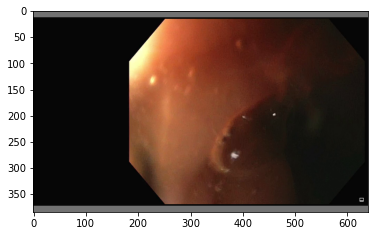

In [83]:
plt.imshow(np.array(im.cpu()[0]).transpose([1,2,0]))

In [75]:
pred = model(im)

In [98]:
pred[0][0].item()

-1.279909372329712

In [20]:
im0 = annotator.result()
if vid_path[i] != save_path:  # new video
    vid_path[i] = save_path
    if isinstance(vid_writer[i], cv2.VideoWriter):
        vid_writer[i].release()  # release previous video writer
    if vid_cap:  # video
        fps = vid_cap.get(cv2.CAP_PROP_FPS)
        w = int(vid_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        h = int(vid_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    else:  # stream
        fps, w, h = 30, im0.shape[1], im0.shape[0]
    save_path = str(Path(save_path).with_suffix('.mp4'))  # force *.mp4 suffix on results videos
    vid_writer[i] = cv2.VideoWriter(save_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (w, h))
vid_writer[i].write(im0)

NameError: name 'annotator' is not defined